# HW2: Spam classification with LSTM

The deadline is **9:30 am Feb 16, 2022**.   
You should submit a `.ipynb` file with your solutions to NYU Brightspace.

---

In this homework, we will reuse the spam prediction dataset used in HW1.
We will use a word-level BiLSTM sentence encoder to encode the sentence and a neural network classifier.

For reference, you may read [this paper](https://arxiv.org/abs/1705.02364).

Lab 3 is especially relevant to this homework.

## Points distribution

1. code `spam_collate_func`: 25 pts
2. code `LSTMClassifier.init`: 25 pts
3. code `LSTMClassifier.forward`: 20 pts
4. code `evaluate`: 10 pts
5. code for training loop: 10 pts
6. Question on early stopping: 10 pts

How we grade the code: 
- full points if code works and the underlying logic is correct;
- half points if code works but the underlying logic is incorrect;
- zero points if code does not work.

Therefore, **make sure your code works, i.e., no error is being produced when you execute the code.**


# Data Loading
First, reuse the code from HW1 to download and read the data.

In [1]:
!wget 'https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR' -O spam.csv

--2022-02-15 00:47:01--  https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR
Resolving docs.google.com (docs.google.com)... 142.250.81.206, 2607:f8b0:4004:82f::200e
Connecting to docs.google.com (docs.google.com)|142.250.81.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/caipad03d3ncrselppk8o4u4lb8k2m1k/1644885975000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download [following]
--2022-02-15 00:47:01--  https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/caipad03d3ncrselppk8o4u4lb8k2m1k/1644885975000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download
Resolving doc-14-04-docs.googleusercontent.com (doc-14-04-docs.googleusercontent.com)... 172.217.164.129, 2607:f8b0:4004:814::2001
Connecting to doc-14-04-docs.googleusercontent.com (doc-14-04-docs.goog

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("spam.csv", usecols=["v1", "v2"], encoding='latin-1')
# 1 - spam, 0 - ham
df.v1 = (df.v1 == "spam").astype("int")
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


We will split the data into train, val, and test sets.  
`train_texts`, `val_texts`, and `test_texts` should contain a list of text examples in the dataset.


In [3]:
# 0.15 for val, 0.15 for test, 0.7 for train
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)

# Shuffle the data
df = df.sample(frac=1)
# Split df to test/val/train
test_df = df[:test_size]
val_df = df[test_size:test_size+val_size]
train_df = df[test_size+val_size:]


train_texts, train_labels = list(train_df.v2), list(train_df.v1)
val_texts, val_labels     = list(val_df.v2), list(val_df.v1)
test_texts, test_labels   = list(test_df.v2), list(test_df.v1)


# Check that idces do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all idces are present
assert df.shape[0] == len(train_labels) + len(val_labels) + len(test_labels)

# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_labels)}\n"
    f"Val size: {len(val_labels)}\n"
    f"Test size: {len(test_labels)}\n"
)

Size of initial data: 5572
Train size: 3902
Val size: 835
Test size: 835



In [4]:
train_texts[:10]  # Just checking the examples in train_text

['Last Chance! Claim ur å£150 worth of discount vouchers today! Text SHOP to 85023 now! SavaMob, offers mobile! T Cs SavaMob POBOX84, M263UZ. å£3.00 Sub. 16',
 'No pic. Please re-send.',
 'Hi baby ive just got back from work and i was wanting to see u allday! I hope i didnt piss u off on the phone today. If u are up give me a call xxx',
 'Haha, my legs and neck are killing me and my amigos are hoping to end the night with a burn, think I could swing by in like an hour?',
 'Shuhui say change 2 suntec steamboat? U noe where? Where r u now?',
 'Aiyo a bit pai seh Ì_ noe... Scared he dun rem who i am then die... Hee... But he become better lookin oredi leh...',
 'Sounds like you have many talents! would you like to go on a dinner date next week?',
 'We are pleased to inform that your application for Airtel Broadband is processed successfully. Your installation will happen within 3 days.',
 "I'm not coming home 4 dinner.",
 "You won't believe it but it's true. It's Incredible Txts! Reply G 

# Download and Load GloVe Embeddings
We will use GloVe embedding parameters to initialize our layer of word representations / embedding layer.
Let's download and load glove.


This is related Lab 3 Deep Learning, please watch the recording and check the notebook for details.


In [5]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2022-02-15 00:47:01--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 142.250.81.206, 2607:f8b0:4004:82f::200e
Connecting to docs.google.com (docs.google.com)|142.250.81.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iepb7b2v6q2si8dtnu5eafrb320ehbi7/1644885975000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2022-02-15 00:47:02--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iepb7b2v6q2si8dtnu5eafrb320ehbi7/1644885975000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)... 172.217.164.129, 2607:f8b0:4004:814::2001
Connecting to doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)|172.217.164.129|:443... con

## Load GloVe Embeddings

In [6]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
        print(embedding_ls[-1].size)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM = 300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

300


In [7]:
embeddings.shape

(50002, 300)

## Import packages

In [8]:
!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
from tqdm.auto import tqdm

# Tokenize text data.
We will use the `tokenize` function to convert text data into sequence of indices.

In [9]:
def tokenize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm(data):
        tokenized = tokenizer.tokenize(ex.lower())
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = tokenize(train_texts, train_labels, tokenizer, vocab)
val_data_indices, val_labels = tokenize(val_texts, val_labels, tokenizer, vocab)
test_data_indices, test_labels = tokenize(test_texts, test_labels, tokenizer, vocab)

  0%|          | 0/3902 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

In [10]:
print("\nTrain text first 5 examples:\n", train_data_indices[:5])
print("\nTrain labels first 5 examples:\n", train_labels[:5])


Train text first 5 examples:
 [[78, 1021, 807, 1549, 10576, 1, 4552, 2549, 1091, 5, 6102, 16036, 375, 807, 2831, 2857, 6, 1, 116, 807, 1, 3, 1730, 2374, 807, 2161, 19342, 1, 1, 3, 1, 1, 4552, 30084, 5522, 4, 698], [86, 1, 3834, 1, 4], [11085, 2234, 1, 122, 407, 139, 27, 163, 7, 43, 17, 7107, 6, 255, 6481, 1, 807, 43, 826, 43, 1, 1, 6481, 140, 15, 2, 1266, 1, 85, 6481, 34, 62, 457, 287, 9, 582, 12895], [1, 3, 194, 4378, 7, 4593, 34, 1030, 287, 7, 194, 1, 34, 2712, 6, 158, 2, 366, 19, 9, 6294, 3, 271, 43, 96, 4925, 23, 8, 119, 31, 1154, 190], [1, 205, 513, 234, 1, 26216, 190, 6481, 39168, 113, 190, 113, 1913, 6481, 116, 190]]

Train labels first 5 examples:
 [1, 0, 0, 0, 0]


# Create DataLoaders (25 pts)
 Now, let's create pytorch DataLoaders for our train, val, and test data.

 `SpamDataset` class is based on torch [`Dataset`](https://pytorch.org/docs/1.7.0/data.html?highlight=dataset#torch.utils.data.Dataset). It has an additional parameter called `self.max_sent_length` and a `spam_collate_func`.

In order to use batch processing, all the examples need to effectively be the same length. We'll do this by adding padding tokens. `spam_collate_func` is supposed to dynamically pad or trim the sentences in the batch based on `self.max_sent_length` and the length of longest sequence in the batch. 
- If `self.max_sent_length` is less than the length of longest sequence in the batch, use `self.max_sent_length`. Otherwise, use the length of longest sequence in the batch.
- We do this because our input sentences in the batch may be much shorter than `self.max_sent_length`.  

Please check the comment block in the code near TODO for more details.


Example: 

* PAD token id = 0
* max_sent_length = 5

input list of sequences:
```
inp = [
    [1,4,5,3,5,6,7,4,4],
    [3,5,3,2],
    [2,5,3,5,6,7,4],
]
```
then padded minibatch looks like this:
```
padded_input = 
    [[1,4,5,3,5],
     [3,5,3,2,0],
     [2,5,3,5,6]]
```

In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    def spam_collate_func(self, batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        # What the input `batch`? That's for you to figure out!
        # You can read the Dataloader documentation, or you can use print
        # function to debug. 
        """ 
        data_list = [] # store padded sequences
        label_list = []

        # the length of longest sequence in batch
        # if it is less than self.max_sent_length
        # else max_batch_seq_len = self.max_sent_length
        max_batch_seq_len = max([len(text[0]) for text in batch]) if max([len(text[0]) for text in batch])<self.max_sent_length else self.max_sent_length

        """
          # Pad the sequences in your data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list
          1. TODO: Your code here 
        """
        for text in batch:
          len_pad = max_batch_seq_len - len(text[0])
          if len_pad > 0:
            text[0].extend([0]*len_pad)
          else:
            text[0] = text[0][:max_batch_seq_len]

          data_list.append(text[0])
          label_list.append(text[1])
        
        data_list = torch.Tensor(data_list).long()
        label_list = torch.Tensor(label_list).long()

        return [data_list, label_list]

BATCH_SIZE = 64
max_sent_length = 128
train_dataset = SpamDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = SpamDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = SpamDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)


Let's try to print out an batch from train_loader.


In [12]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([64, 39])
data_batch:  tensor([[ 5286,    43,   171,  ...,     0,     0,     0],
        [ 3004,    14,    81,  ...,     0,     0,     0],
        [13077,     3,    21,  ...,     0,     0,     0],
        ...,
        [  116,   171,  1067,  ...,     0,     0,     0],
        [  394,  3008,  4834,  ...,     0,     0,     0],
        [  102,   104,   121,  ...,     0,     0,     0]])
labels:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


# Build a BiLSTM Classifier (20 + 25 + 10 pts)

Now we are going to build a BiLSTM classifier. Check this [blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [`torch.nn.LSTM`](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) for reference. Recall that we've also seen LSTM in Lab 3. 

The hyperparameters for LSTM are already given, but they are not necessarily optimal. You should get a good accuracy with these hyperparameters but you may try to tune the hyperparameters and use different hyperparameters to get better performance.

* `__init__`: Class constructor. Here we define layers / parameters of LSTM.
* `forward`: This function is used whenever you call your object as `model()`. It takes the input minibatch and returns the output representation from LSTM.

In [13]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """
    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        """
           Define the components of your BiLSTM Classifier model
           2. TODO: Your code here
        """
        self.dropout = nn.Dropout(p=dropout_prob)
        self.lstm = nn.LSTM(input_size=embeddings.shape[1], 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            bidirectional=bidirectional)
        
        self.non_linearity = nn.ReLU()  # For example, ReLU
        self.clf = nn.Linear(in_features=hidden_size*2, 
                             out_features=num_classes) # classifier layer

        # raise NotImplementedError  # delete this line
    
    def load_pretrained_embeddings(self, embeddings):
        """
           The code for loading embeddings from Lab 3 Deep Learning
           Unlike lab, we are not setting `embedding_layer.weight.requires_grad = False`
           because we want to finetune the embeddings on our data
        """
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer


    def forward(self, inputs):
        logits = None
        """
           Write forward pass for LSTM. You must use dropout after embedding
           the inputs. 

           Example, forward := embedding -> bilstm -> pooling (sum?mean?max?) 
                              nonlinearity -> classifier
           Refer to: https://arxiv.org/abs/1705.02364

           Return logits

           3. TODO: Your code here
        """
        embed = self.embedding_layer(inputs)
        embed = self.dropout(embed)

        out, hidden = self.lstm(embed)
        # out dim: batch_size * sequence length * (hidden_size*2)

        pool = nn.MaxPool1d(out.shape[1])
        out = pool(out.permute(0,2,1)).permute(0,2,1).view(-1, hidden_size*2)
        # out dim: batch_size * (hidden_size*2)

        out = self.non_linearity(out)
        # out dim: batch_size * (hidden_size*2)
        
        logits = self.clf(out)
        # out dim: batch_size * num_classes

        return logits

First, we will define an evaluation function that will return the accuracy of the model. We will use this to compute validation accuracy and test accuracy of the model given a dataloader.

In [14]:
def evaluate(model, dataloader, device):
    accuracy = None
    model.eval()
    """
        4. TODO: Your code here
        Calculate the accuracy of the model on the data in dataloader
        You may refer to `run_inference` function from Lab 3 part 1.
    """
    with torch.no_grad():
        pred_list = []
        label_list = []
        
        for batch_text, batch_labels in dataloader:
            pred = model(batch_text.to(device))
            _, pred_label = torch.max(pred, 1, keepdim=False, out=None)
            pred_list.append(pred_label.detach().cpu().numpy())
            label_list.append(batch_labels.detach().cpu().numpy())
            
    preds = np.concatenate(pred_list, axis=0) 
    labels = np.concatenate(label_list, axis=0) 
     
    accuracy = (preds==labels).mean()
    return accuracy 

# Initialize the BiLSTM classifier model, criterion and optimizer


In [15]:
# BiLSTM hyperparameters
hidden_size = 32
num_layers = 1
num_classes = 2
bidirectional = True
torch.manual_seed(1234)

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model with early stopping (10 pts)

Train the model for `NUM_EPOCHS`. 
Keep track of training loss.  
Compute the validation accuracy after each epoch. Keep track of the best validation accuracy and save the model with the best validation accuracy.  

If the validation accuracy does not improve for more than `early_stop_patience` number of epochs in a row, stop training. 


In [16]:
train_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience = 2
NUM_EPOCHS = 10
  
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()  # this enables dropout/regularization
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        """
           Code for training lstm
           Keep track of training of for each batch using train_loss_history
        """
        preds = model(data_batch.to(device))
        loss = criterion(preds, batch_labels.to(device))
        """
          5(1). TODO: Recall that pytorch training involves five critical
          components, as discussed in the Lab. Some of the components are
          still missing here. Your code here.
        """
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_history.append(loss.item())
        # raise NotImplementedError  # delete this line

    """
        Code for tracking best validation accuracy, saving the best model, and early stopping
        # Compute validation accuracy after each training epoch using `evaluate` function
        # Keep track of validation accuracy in `val_accuracy_history`
        # save model with best validation accuracy, hint: torch.save(model, 'best_model.pt')
        # Early stopping: 
        # stop training if the validation accuracy does not improve for more than `early_stop_patience` runs
        5(2). TODO: Your code here
    """

    acc = evaluate(model, val_loader, device)
    print("epoch: ", epoch+1, "Val Accuracy: ", acc)

    # method 1: 
    # if the validation accuracy has not got better than the BEST validation accuracy for _ epochs
    if val_accuracy_history == []:
      best_val_accuracy = 0
      torch.save(model, 'best_model.pt')
    else:
      if acc > max(val_accuracy_history):
        torch.save(model, 'best_model.pt')
      else: 
        n_no_improve += 1
    val_accuracy_history.append(acc)

    # # method 2
    # # compare the validation accuracy of epoch j with the validation accuracy of epoch j-1 
    # if val_accuracy_history == []:
    #   torch.save(model, 'best_model.pt')
    # else:
    #   if acc > max(val_accuracy_history):
    #     torch.save(model, 'best_model.pt')
    # val_accuracy_history.append(acc)

    # if len(val_accuracy_history) > early_stop_patience:
    #   if val_accuracy_history[-1] <= val_accuracy_history[-2]:
    #     n_no_improve += 1
    #   else:
    #     n_no_improve = 0

    if n_no_improve > early_stop_patience:
      print("Early stopped at epoch :" , epoch+1)
      break
    else:
      continue

    if n_no_improve > early_stop_patience:
      print("Early stopped at epoch :" , epoch+1)
      break
    else:
      continue

best_val_accuracy = max(val_accuracy_history)
    # The end of a training epoch 
    # raise NotImplementedError  # delete this line

print("Best validation accuracy is: ", best_val_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch:  1 Val Accuracy:  0.9772455089820359
epoch:  2 Val Accuracy:  0.98562874251497
epoch:  3 Val Accuracy:  0.9892215568862276
epoch:  4 Val Accuracy:  0.9844311377245509
epoch:  5 Val Accuracy:  0.9844311377245509
epoch:  6 Val Accuracy:  0.98562874251497
Early stopped at epoch : 6
Best validation accuracy is:  0.9892215568862276


#Question: Why do we want to use early stopping? Write the most important reason in concise way. (10 pts)

Your answer: 
- Keep training the model iteratively can easily lead to overfitting problems, since the model may memorize the data rather than own fancy generalization ability, to achieve great performance during fitting the training set. 
- Early stopping can serve as a regularizor to prevent the model from learning once it detects that the validation score cannot be improved anymore, which indicates that the model's ability to generalize has already been optimized.

# Draw training curve 
X-axis: training steps, Y-axis: training loss

Make sure to draw your own curves. 

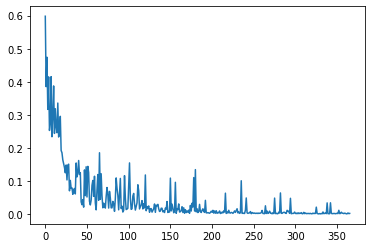

In [17]:
pd.Series(train_loss_history).plot()

# Validation accuracy curve
X-axis: Epochs, Y-axis: validation accuracy

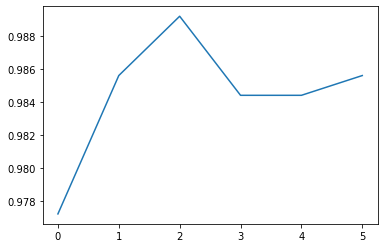

In [18]:
pd.Series(val_accuracy_history).plot()

## You should expect to get test accuracy > 0.95.

In [19]:
# Reload best model from saved checkpoint
# Compute test accuracy
model = torch.load('best_model.pt')
test_accuracy = evaluate(model, test_loader, device)
print(test_accuracy)

0.9916167664670659
